# Model Training and Basic Optimization

<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg" height="150">

> *Basi Fondamentali del Machine Learning*
> 
> Day 4 - 14/10/2024
> 
> Micheal Wood, Maciej Sakwa, Emanuele Ogliari

![Pikachu-Training](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/pikachu-training.gif?raw=true)


## Outline

1. Machine Learning Project Structure (review)
2. Linear Regression Training
3. Neural Network Training


## Learning obejctives

* Understand how a line can be fit to data in 2D and 3D
* See the analogy between a simple line fit and training a neural network
* Follow the math and reason for Mean Squared Error
* Gennerally follow how gradient descent and error backpropagation work

---

# Machine Learning Project Structure (review)

- ML is often called a **black-box**, but it's not a *magic* black-box
- You can not solve *any* problem using *any* data
- The data and model need to be appropriate for the problem
- General project structure is repeated
  - Data changes
  - Model changes

![structure](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/project-structure.png?raw=true)

## 1. Problem definition

**Predict the Spanish electricity price at time `t` from the day-ahead price and other generation data at time `t`.**

|I/O|  Data |
| --- | --- |
|Inputs| `price day ahead`, `generation fossil hard coal`, etc |
|Target|  `price actual` |
|Output| `price actual estimate` |



## 2. Data collection and engineering

Import the packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format # print 2 decimal places
pd.options.mode.chained_assignment = None

def import_data(filepath,drop=[]):
    df = pd.read_csv(filepath,index_col='time',).drop(columns=drop)
    df.index = pd.to_datetime(df.index,utc=True,format='ISO8601')
    df.index = df.index.tz_convert('Europe/Madrid').tz_localize(None)
    return df

One data set:
1. The electricity generation and prices in Spain

In [2]:
data = import_data('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/energy_supply.csv',
                   drop=['generation hydro pumped storage aggregated','forecast wind offshore eday ahead'])
data

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.00,329.00,0.00,4844.00,4821.00,162.00,0.00,0.00,0.00,863.00,...,49.00,196.00,0.00,6378.00,17.00,6436.00,26118.00,25385.00,50.10,65.41
2015-01-01 01:00:00,449.00,328.00,0.00,5196.00,4755.00,158.00,0.00,0.00,0.00,920.00,...,50.00,195.00,0.00,5890.00,16.00,5856.00,24934.00,24382.00,48.10,64.92
2015-01-01 02:00:00,448.00,323.00,0.00,4857.00,4581.00,157.00,0.00,0.00,0.00,1164.00,...,50.00,196.00,0.00,5461.00,8.00,5454.00,23515.00,22734.00,47.33,64.48
2015-01-01 03:00:00,438.00,254.00,0.00,4314.00,4131.00,160.00,0.00,0.00,0.00,1503.00,...,50.00,191.00,0.00,5238.00,2.00,5151.00,22642.00,21286.00,42.27,59.32
2015-01-01 04:00:00,428.00,187.00,0.00,4130.00,3840.00,156.00,0.00,0.00,0.00,1826.00,...,42.00,189.00,0.00,4935.00,9.00,4861.00,21785.00,20264.00,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.00,0.00,0.00,7634.00,2628.00,178.00,0.00,0.00,0.00,1.00,...,85.00,277.00,0.00,3113.00,96.00,3253.00,30619.00,30653.00,68.85,77.02
2018-12-31 20:00:00,296.00,0.00,0.00,7241.00,2566.00,174.00,0.00,0.00,0.00,1.00,...,33.00,280.00,0.00,3288.00,51.00,3353.00,29932.00,29735.00,68.40,76.16
2018-12-31 21:00:00,292.00,0.00,0.00,7025.00,2422.00,168.00,0.00,0.00,0.00,50.00,...,31.00,286.00,0.00,3503.00,36.00,3404.00,27903.00,28071.00,66.88,74.30


Summary statistics

In [3]:
data.describe() # add .T to rotate (transpose) the table if you want

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35046.00,35045.00,35046.00,35046.00,35046.00,35045.00,...,35046.00,35045.00,35046.00,35046.00,35064.00,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,0.00,5622.74,4256.07,298.32,0.00,0.00,0.00,475.58,...,1432.67,269.45,0.00,5464.48,1439.07,5471.22,28712.13,28696.94,49.87,57.88
std,85.35,354.57,0.00,2201.83,1961.60,52.52,0.00,0.00,0.00,792.41,...,1680.12,50.20,0.00,3213.69,1677.70,3176.31,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,237.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,0.00,4126.00,2527.00,263.00,0.00,0.00,0.00,0.00,...,71.00,240.00,0.00,2933.00,69.00,2979.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,0.00,4969.00,4474.00,300.00,0.00,0.00,0.00,68.00,...,616.00,279.00,0.00,4849.00,576.00,4855.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,0.00,6429.00,5838.75,330.00,0.00,0.00,0.00,616.00,...,2578.00,310.00,0.00,7398.00,2636.00,7353.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,0.00,20034.00,8359.00,449.00,0.00,0.00,0.00,4523.00,...,5792.00,357.00,0.00,17436.00,5836.00,17430.00,41390.00,41015.00,101.99,116.80


There's a lot of zeros in some columns, which are not useful to us. Ciao!

In [4]:
zeros_list = ['generation fossil coal-derived gas',
              'generation fossil oil shale',
              'generation fossil peat',
              'generation geothermal',
              'generation marine',
              'generation wind offshore']
nonzeros_list = [x for x in data.columns if x not in zeros_list]

data = data[nonzeros_list]

There's also lot of NaNs (not a number), which are not useful to us

In [5]:
data.isna().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


Replace the NaNs with nearby values. Ciao!

In [6]:
data = data.ffill()

We can quantify the correlations by calling the .corr() function. By default, it calculates the pearsons coefficient between each column in the dataframe:

>Note that this is a measure of _linear_ relationship!

In [7]:
data.corr()['price actual'].sort_values(ascending=False).to_frame()

,price actual
price actual,1.00
price day ahead,0.73
generation fossil hard coal,0.47
generation fossil gas,0.46
total load forecast,0.44
total load actual,0.44
generation fossil brown coal/lignite,0.36
generation fossil oil,0.29
generation other renewable,0.26
generation waste,0.17


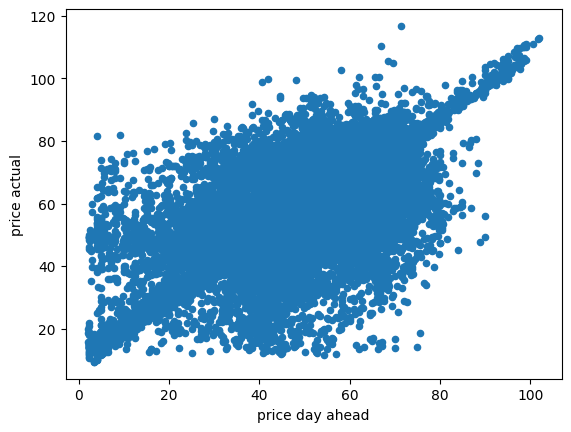

In [8]:
data.plot(x='price day ahead',y='price actual',kind='scatter');

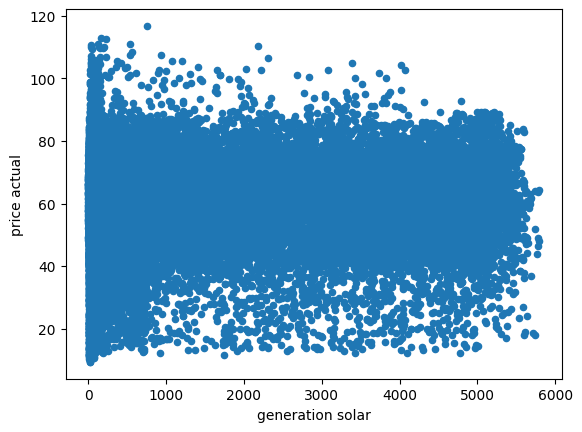

In [9]:
data.plot(x='generation solar',y='price actual',kind='scatter');

The actual price is highly correlated positively with
- the day ahead price (obviously)
- but also with fossil fuel based generation
- and total generation needed

So the more energy we need, and the more fossil fuels produce, the more expensive the energy gets.

Actual price is negavitely correlated with cheap sources like
- hydro-based generation
- and with wind-based generation 
 
Surprisingly the PV-based production has low impact on the price. 

Remember in supervised learning:
- Inputs are **features**
- Outputs are what _do_ come out of the model
- What we _want_ from the model are **targets** (or labels)

In our case, we want to estimate the actual energy price using the generation data, let's extract the corresponding columns:

In [10]:
input_columns = data.columns.to_list() 
input_columns.remove('price actual')    # Inputs are all columns except for the 'price actual'

In [11]:
inputs = data[input_columns].copy()
targets = data[['price actual']].copy()

For now we don't do any modifications to the **features** we have in the dataset, let's see what results we get with almost *raw* data.

## 3. Model build and train

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

To avoid bias in fitting we **scale** the input data. The two most common methods are:

- **min-max scaling** 
- standard scaling

In [13]:
scaler = MinMaxScaler() 

In [14]:
inputs_scaled = scaler.fit_transform(inputs) 
labels_scaled = targets.values.ravel()

Split the inputs and the labels in train and test subgroups

In [15]:
n = len(inputs) 
cutoff = int(0.7*n) # Train on 70% of the data, test on 30%

train_inputs = inputs_scaled[:cutoff]   # Cut before
train_targets = labels_scaled[:cutoff]   # Cut before

test_inputs = inputs_scaled[cutoff:]    # Cut after
test_targets = labels_scaled[cutoff:]    # Cut after

Visually:

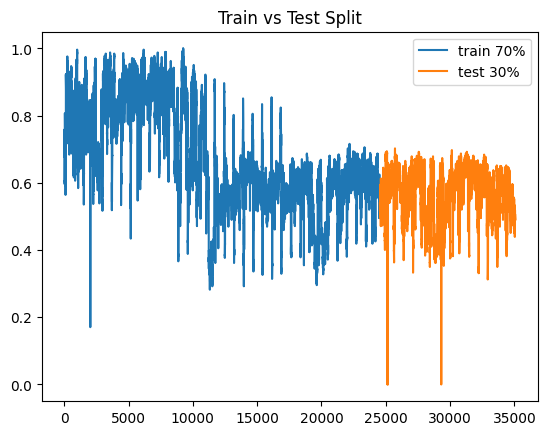

In [16]:
plt.plot(np.arange(0, cutoff), train_inputs[:, 0],label='train 70%')
plt.plot(np.arange(cutoff, n), test_inputs[:, 0],label='test 30%')
plt.legend()
plt.title('Train vs Test Split')
plt.show()

Create empty model:

In [17]:
model = LinearRegression()

Train (`fit`) the model to estimate the targets given the inputs:

In [18]:
model.fit(X=train_inputs, y=train_targets)

LinearRegression()

Finally, we can call the `.predict()` method with test inputs to see how the model performs with unseen data:

In [19]:
results = model.predict(test_inputs)

We can quickly visualise the results with a plot (we can declare it in a function to quickly reuse it later):

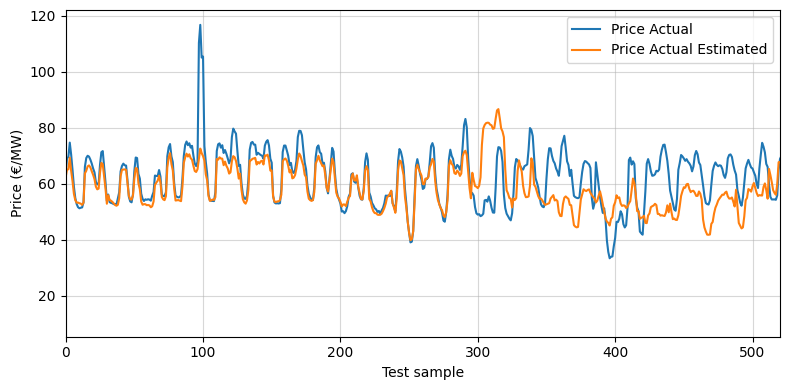

In [20]:
plt.figure(figsize=(8, 4))

# Plots
plt.plot(test_targets, label='Price Actual')
plt.plot(results, label='Price Actual Estimated')

# Visuals
plt.xlim((0,520))
plt.xlabel('Test sample')
plt.ylabel('Price (€/MW)')
plt.grid(which='major', alpha = 0.5)

# Tidy up
plt.legend()
plt.tight_layout()
plt.show()

## 4. Evaluate results

We want to evaluate the model(s) using metrics that help us make a decision.

First, for notation:
- $y_{true}$ are the true values (`test_labels` in our case)
- $y_{pred}$ are the predicted values

Two common mean-type (average) metrics in regression problems are:

* mean absolute error: $ MAE = |y_{true}-y_{pred}| $ 
* mean squared error: $ MSE = |(y_{true}-y_{pred})^2| $ 

We can also take the square root of $MSE$ so that we come back to the original units (e.g. kW):
* root mean square error: $ RMSE = \sqrt{MSE}$

Let's define a function that takes the results and the labels and outputs the metrics:

In [21]:
def print_results(model, results, targets):
    
    # Calculate the metrics using the labels and the results
    mae = (targets-results).__abs__().mean()
    mse = ((targets-results)**2).mean()
    rmse = np.sqrt(mse)
    mape = (mae / targets).mean()
    
    # Print out the results
    print(f'Results for model {model}: \n- MAE:\t{mae:.02f}\n- MSE:\t{mse:.02f}\n- RMSE:\t{rmse:.02f}\n- MAPE:\t{mape*100:.02f}%')

In [22]:
print_results('Linear Regression',results,test_targets)

Results for model Linear Regression: 
- MAE:	5.93
- MSE:	87.96
- RMSE:	9.38
- MAPE:	9.94%


---
# Linear Regression Training

Today we focus on training.

We sometimes say fitting for more simple linear models.

## "By hand"

Earlier we saw `price day ahead` and `price actual` correlated well (0.79).

Indeed, they look similar.

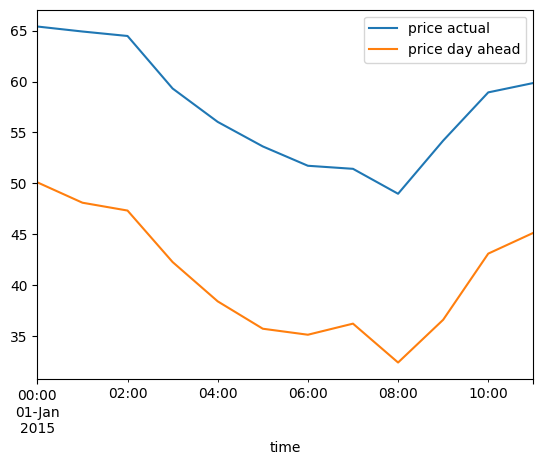

In [23]:
data[['price actual','price day ahead']][:12].plot();

Let's look again at the scatter plot to see the correlation

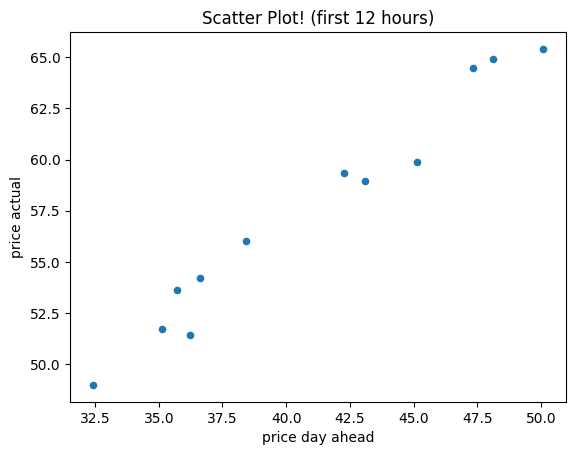

In [24]:
data[:12].plot(x='price day ahead',
               y='price actual',
               kind='scatter',
               title='Scatter Plot! (first 12 hours)');

Now, taking the data..

In [25]:
data[['price day ahead','price actual']][:12]

,price day ahead,price actual
time,,
2015-01-01 00:00:00,50.10,65.41
2015-01-01 01:00:00,48.10,64.92
2015-01-01 02:00:00,47.33,64.48
2015-01-01 03:00:00,42.27,59.32
2015-01-01 04:00:00,38.41,56.04
2015-01-01 05:00:00,35.72,53.63
2015-01-01 06:00:00,35.13,51.73
2015-01-01 07:00:00,36.22,51.43
2015-01-01 08:00:00,32.40,48.98


... build and "fit" model `y=w*x+b` where

- `x` is `price day ahead` (input)

- `y` is `price actual` (label)

- `w` and `b` are your choice

Start with the last row of data:

In [26]:
# w*(x) + b
1.1*(45.14) + 10.2

59.854

Here we "fit" the model on just one data point.

And we can "test" on the other ones:

In [27]:
1.1*(43.10) + 10.2

57.61

In [28]:
1.1*(36.6) + 10.2

50.46000000000001

Faster this way:

In [29]:
data['price actual estimate'] = 1.1*data['price day ahead'] + 10.2
data[['price day ahead','price actual','price actual estimate']][:12]

,price day ahead,price actual,price actual estimate
time,,,
2015-01-01 00:00:00,50.10,65.41,65.31
2015-01-01 01:00:00,48.10,64.92,63.11
2015-01-01 02:00:00,47.33,64.48,62.26
2015-01-01 03:00:00,42.27,59.32,56.70
2015-01-01 04:00:00,38.41,56.04,52.45
2015-01-01 05:00:00,35.72,53.63,49.49
2015-01-01 06:00:00,35.13,51.73,48.84
2015-01-01 07:00:00,36.22,51.43,50.04
2015-01-01 08:00:00,32.40,48.98,45.84


A plotting function:

In [30]:
def plot_scatter_line(df,
                      x='price day ahead',
                      y='price actual',
                      yline='price actual estimate',
                      w=None,
                      b=None,
                      show_errors=False,
                      limit=12):
    df = df[:limit].sort_values(x).copy()

    f = df.plot(x=x,y=y,kind='scatter',label='data',title=f'Scatter Plot (first {limit} h)',xlabel=x+' (x)',ylabel=y+' (y)')  
    if w is not None:
        df[yline] = w*df[x] + b
    if yline in df.columns:
        f.plot(df[x],df[yline],color='red',label='line fit',linestyle='--')    
        f.title.set_text(f'Scatter Plot with Line Fit')
    if show_errors:
        label=None
        for i,(_x,_y,_yp) in enumerate(zip(df[x],df[y],df[yline])):
            if i == len(df[x])-1:
                label = 'errors'
            f.plot([_x, _x], [_y, _yp], color='green', linestyle='-', linewidth=1,label=label,)
        mse = ((df[y]-df[yline])**2).mean()
        f.title.set_text(f'Mean of squared errors: {mse:.2f}')
    f.legend()

Let's see it!

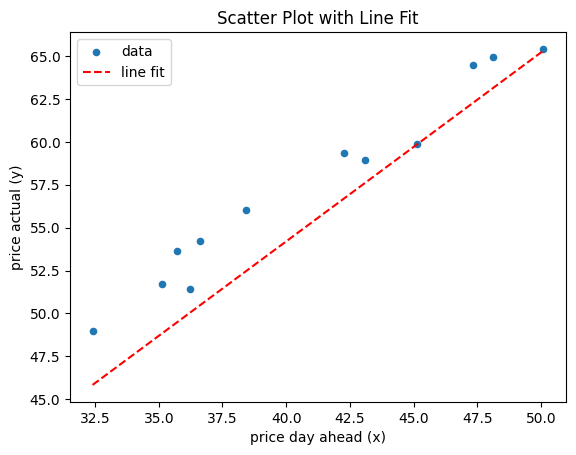

In [31]:
plot_scatter_line(data)

Not bad, but we can do better

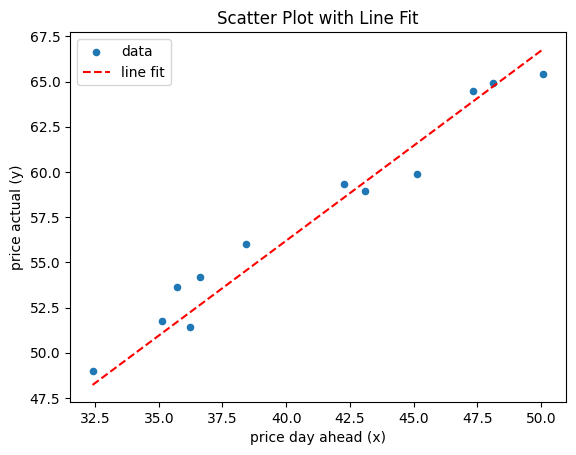

In [32]:
data['price actual estimate'] = 1.05*data['price day ahead'] + 14.2

plot_scatter_line(data)

Question, can we quantify the "fit"?

The vertical distances from the data to the line are the errors, or **residuals.**

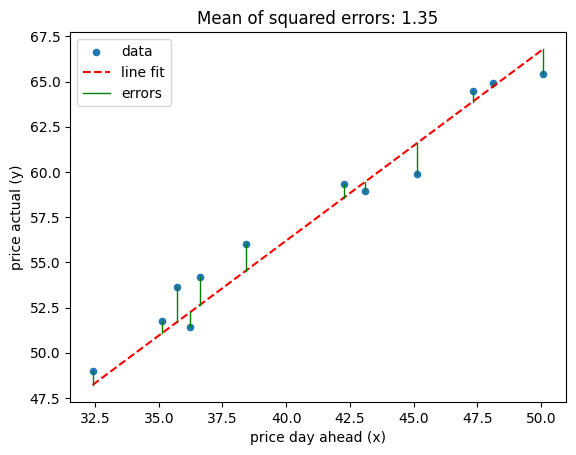

In [33]:
plot_scatter_line(data,show_errors=True)

### Least squares

We always want less total error.

Mathematically, we want to *minimize* the *sum* of errors.

But, do you prefer the errors of model A or B?

| Model | Errors | Sum |
| --- | --- | --- |
| A | -10, 10 | 0 |
| B | -1, 1| 0 |

Probably B. Why? Because the sum of the _absolute value_ of errors is smaller.

| Model | Errors | Aboslute Errors | Sum of Absolute Errors |
| --- | --- | --- | --- |
| A | -10, 10 | 10,10 | 20 |
| B | -1, 1| 1,1 | 2 |

Squaring a number is a kind of absolute value, and is faster for your computer.

| Model | Errors | Sum of Squared Errors |
| --- | --- | --- |
| A | -10, 10 | 200 |
| B | -1, 1| 2 |

Lasty we prefer the mean, so we can compare for different numbers of data points.

| Model | Errors | Mean of Squared Errors |
| --- | --- | --- |
| A | -10, 10 | 100 |
| B | -1, 1| 1 |
| C | -1, 1, -1, -1, 1| 1 |

Let's visualize it.

In the image below:

- The red line is fit to the yellow dot data
  - Each red square is the _square of the error_ for each dot
- The blue line is not fit
  - Each blue square is the _square of the error_ for each dot

![interactive-regression](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/interactive-regression.png?raw=true)



**The sum of the red square areas is less than the sum of the blue squares areas.**
- The red line has the **least squares**
- If the sum is less, so is the mean

This is the famous **mean squared error**

Here's the interactive version: [Least Squares Regression](https://phet.colorado.edu/sims/html/least-squares-regression/latest/least-squares-regression_all.html)

## Machine Learning

That was a lot of work! Machine learning is much faster.

For now we repeat the same problem.

### 2-dimensions

Remember the steps:

1) Problem definition (unchanged)

2) Data collect and engineer

In [34]:
x = data[['price day ahead']][:12]
y = data['price actual'][:12]

3) Model build and train

In [35]:
# y = w*x + b
model = LinearRegression()
model.fit(x, y)

print('w =',model.coef_[0])
print('b =',model.intercept_)

w = 0.9403175521345777
b = 18.97461952724558


4) Evaluate results

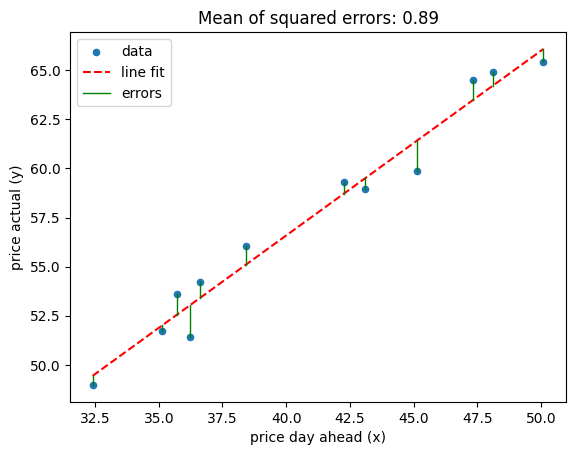

In [36]:
data['price actual estimate'] = data['price day ahead']*model.coef_[0] + model.intercept_
plot_scatter_line(data,show_errors=True)

### Forecast

So far we are always fitting and predicting on the first 12 hours of data.

Here is the **forecast** of the *next* 12 hours, fit on the *first* 12 hours:

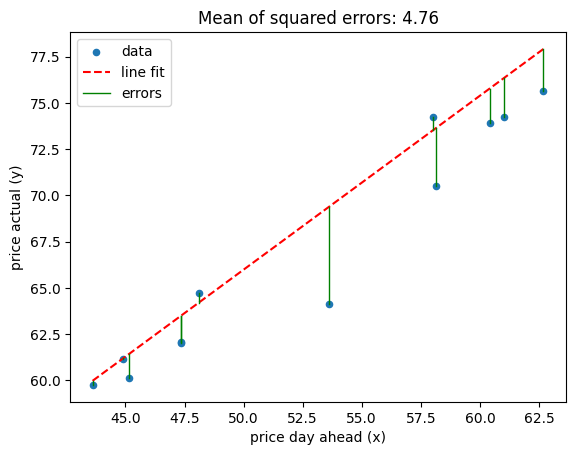

In [37]:
plot_scatter_line(data[12:24],show_errors=True)

Plotting function:

In [38]:
def plot_timeseries(df,
                    x='price day ahead',
                    y='price actual',
                    yhat='price actual estimate',
                    w=None,
                    b=None,
                    test_split = None,
                    limit=24):    
    df = df[[x,y,yhat]][:limit].copy()
    
    if test_split is not None:
        train = pd.DataFrame({x:df[x].values[:test_split],
                              y:df[y].values[:test_split],
                              yhat:df[yhat].values[:test_split],},
                            index=df.index[:test_split])
        test = pd.DataFrame({'test '+x:df[x].values[test_split:],
                        'test '+y:df[y].values[test_split:],
                        'test '+yhat:df[yhat].values[test_split:]},
                   index=df.index[test_split:])
        f = pd.concat((train,test),axis=1).plot(figsize=(10,5))
        if w is not None:
            yhat = yhat+f' ({w:.2f}*x + {b:.2f})'
        legend = ['train '+x+' (y)','train '+y+' (x)','train '+yhat,'test '+x,'test '+y,'test '+yhat]
    else:
        f = df.plot(figsize=(10,5))
        if w is not None:
            yhat = yhat+f' ({w:.2f}*x + {b:.2f})'
        legend = [x,y,yhat]
    f.title.set_text('Time Series Plot')
    

    f.legend(legend)

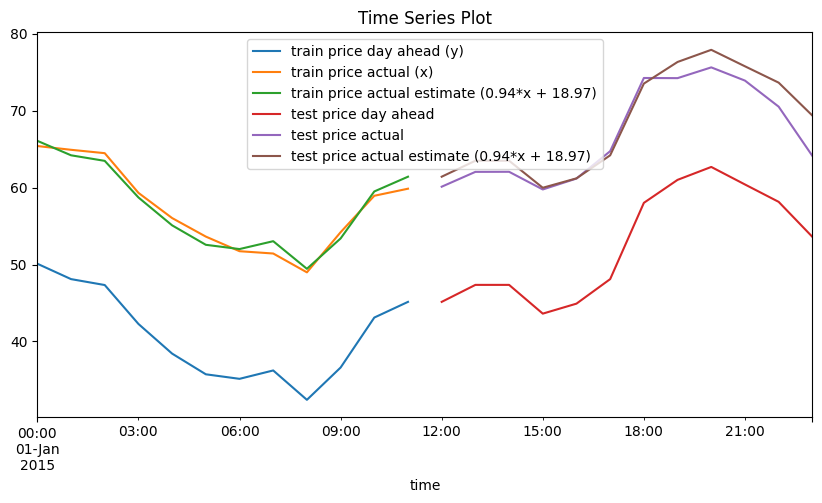

In [39]:
plot_timeseries(data,w=model.coef_[0],b=model.intercept_,test_split=12)

### More data: 48 h

In [40]:
x = data[['price day ahead']][:48]
y = data['price actual'][:48]

In [41]:
# y = w*x + b
model = LinearRegression()
model.fit(x, y)

print('w =',model.coef_[0])
print('b =',model.intercept_)

w = 0.07363456403386417
b = 63.40983720046266


What happened?

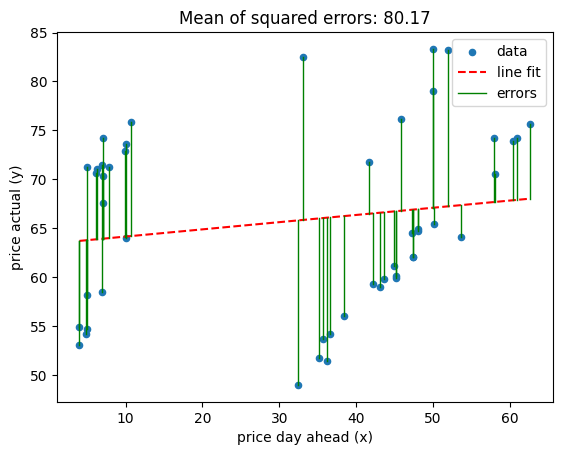

In [42]:
data['price actual estimate'] = data['price day ahead']*model.coef_[0] + model.intercept_
plot_scatter_line(data,show_errors=True,limit=48)

The data is not linear and we have a linear model :)

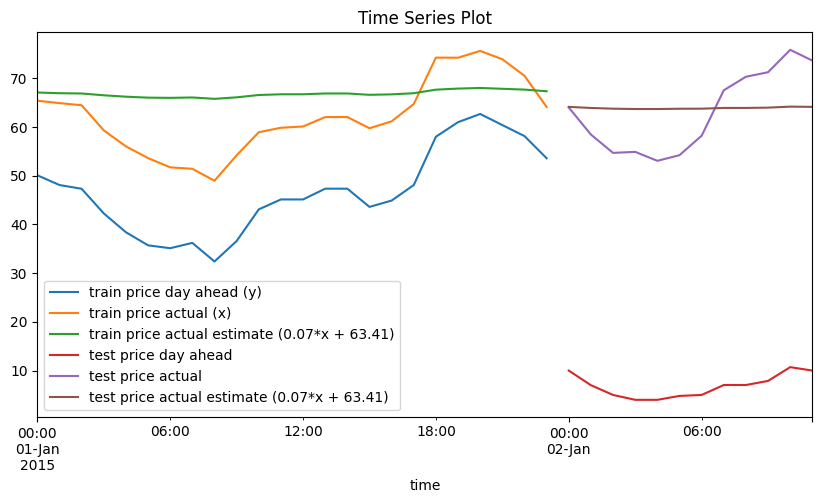

In [43]:
plot_timeseries(data,w=model.coef_[0],b=model.intercept_,test_split=24,limit=36)

### 3-dimensions

So far everything is 2-dimensional:

|I/O | Dimension | Data |
| --- | --- | --- |
|Input| `x` | `price day ahead` |
|Target| `y` | `price actual` |
|Output| `y` | `price actual estimate` |

That's boring. Let's add a third dimension:

|I/O | Dimension | Data |
| --- | --- | --- |
|Input| `x1` | `price day ahead` |
|Input| `x2` | `generation fossil hard coal` |
|Target| `y` | `price actual` |
|Output| `y` | `price actual estimate` |

In [44]:
data[['price day ahead','generation fossil hard coal','price actual']][:12]

,price day ahead,generation fossil hard coal,price actual
time,,,
2015-01-01 00:00:00,50.10,4821.00,65.41
2015-01-01 01:00:00,48.10,4755.00,64.92
2015-01-01 02:00:00,47.33,4581.00,64.48
2015-01-01 03:00:00,42.27,4131.00,59.32
2015-01-01 04:00:00,38.41,3840.00,56.04
2015-01-01 05:00:00,35.72,3590.00,53.63
2015-01-01 06:00:00,35.13,3368.00,51.73
2015-01-01 07:00:00,36.22,3208.00,51.43
2015-01-01 08:00:00,32.40,3335.00,48.98


Plotting function:

In [45]:
def plot_scatter_plane_3d(df,
                          x='price day ahead',
                          y='generation fossil hard coal',
                          z='price actual',
                          yplane='plane fit',
                          limit=12):
    import plotly.graph_objects as go
    from sklearn.linear_model import LinearRegression


    fig = go.Figure(data=[go.Scatter3d(
        x=df[x][:limit],
        y=df[y][:limit],
        z=df[z][:limit],
        mode='markers',
        name='data',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8 )   )])
    
    X = df[[x, y]][:limit]
    Z = df[z][:limit]
    
    model = LinearRegression()
    model.fit(X, Z)
    
    xx, yy = np.meshgrid(np.linspace(X[x].min(), X[x].max(), 10), np.linspace(X[y].min(), X[y].max(), 10))
    zz = model.intercept_ + model.coef_[0] * xx + model.coef_[1] * yy
    
    fig.add_trace(go.Surface(
        x=xx,
        y=yy,
        z=zz,
        colorscale='Viridis',
        opacity=0.5,
        name='plane fit',
    ))    

    fig.update_layout(
        scene=dict(xaxis_title=x,yaxis_title=y,zaxis_title=z),
        title=f'Scatter 3D Plot (first {limit} h)')

    # Show plot
    fig.show()

In [46]:
plot_scatter_plane_3d(data)

The plane is the line fit, but in 3D instead of 2D.

Two thought experiments:

1) 3D to 2D
- Rotate the plot so `generation fossil hard coal` goes _into_ the screen
- You are seeing just the 2D correlation _without_ coal
- Or rotate the plot so `price day ahead` goes _into_ the screen
- You are seeing just the 2D correlation _with_ coal

2) 2D to 3D
- Go back up to one of the 2D plots above
- Pretend there is a third axis going _into_ the screen
- That axis is `generation fossil hard coal`

---
# Neural Network Training

Shockingly, a neural network is just a lot of fitting `w`'s and `b`'s to data.

- Note the activation function: sigmoid (σ) here

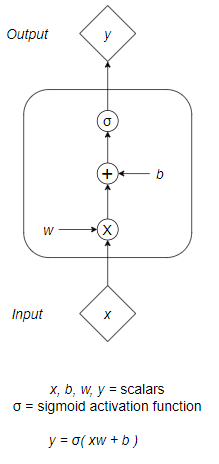



Hyperplane
- But the neural network usually doesn't make a line, or a plane
- Instead, with all the many `w` and `b` parameters we say a **hyperplane** is made
- Note its not flat: the activiation function makes neurons **non-linear**

Parameter Optimization
- How do we choose the right `w`s and `b`s to minimize mean squared error?
- Minimize (optimize) the mean squared error!
- Using a combination of two methods:

1. **gradient descent**
<img src="https://i.pinimg.com/originals/0c/e9/07/0ce90753f7605cc0b26c0e96597ae9e2.gif" width=600>

1. **backpropagation of errors**
<img src="https://robodk.com/blog/wp-content/uploads/2023/11/NeuralNetwork-Training.gif" width=600>




Excellent video explanation: [3 Brown 1 Blue - What is Backpropagation Really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

## Single Neuron

Weights: [array([[2.89961463]]), array([[6.03426891]])]
Biases: [array([7.34457063]), array([4.6722946])]
Number of iterations: 11062
Loss: 0.48096401678015255
Best loss: 0.48096401678015255
Number of layers: 3
Number of outputs: 1

Mean Squared Error (train): 0.8377066191160575
Mean Squared Error: (test) 2.0412211695160543


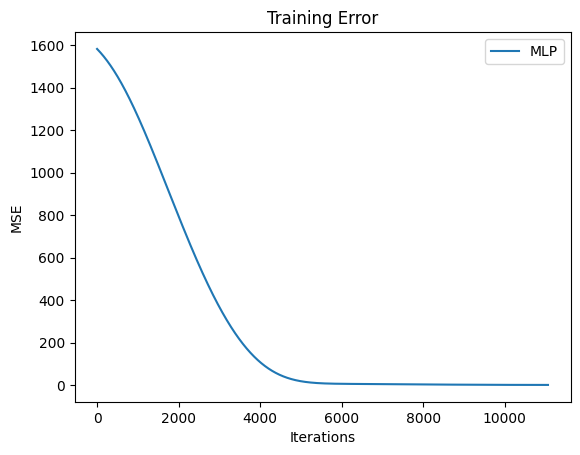

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:24].copy()
y = data['price actual'][:24].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(1,),
                   max_iter=100000,
                   random_state=42,
                   #early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

Plotting function:

In [48]:
def plot_scatter_mlp(df,
                      x='price day ahead',
                      y='price actual',
                      ymlp='price mlp fit',
                      show_errors=False,
                      limit=12):
    df = df[:limit].sort_values(x).copy()

    f = df.plot(x=x,y=y,kind='scatter',label='data',title=f'Scatter Plot (first {limit} h)',xlabel=x+' (x)',ylabel=y+' (y)')  
    if ymlp in df.columns:
        f.plot(df[x],df[ymlp],label='mlp fit',color='red',)    
        f.title.set_text(f'Scatter Plot with MLP Fit')
    if show_errors:
        label=None
        for i,(_x,_y,_yp) in enumerate(zip(df[x],df[y],df[ymlp])):
            if i == len(df[x])-1:
                label = 'errors'
            f.plot([_x, _x], [_y, _yp], color='green', linestyle='-', linewidth=1,label=label,)
        mse = ((df[y]-df[ymlp])**2).mean()
        f.title.set_text(f'Mean of squared errors: {mse:.2f}')
    f.legend()

On the first 12 hours it basically finds the same line as the linear regression.

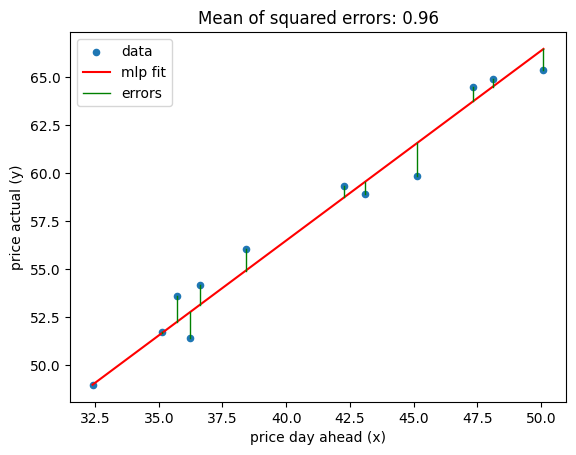

In [49]:
plot_scatter_mlp(train,show_errors=True)

The next 12 hour **forecast** is a little worse than the regression.

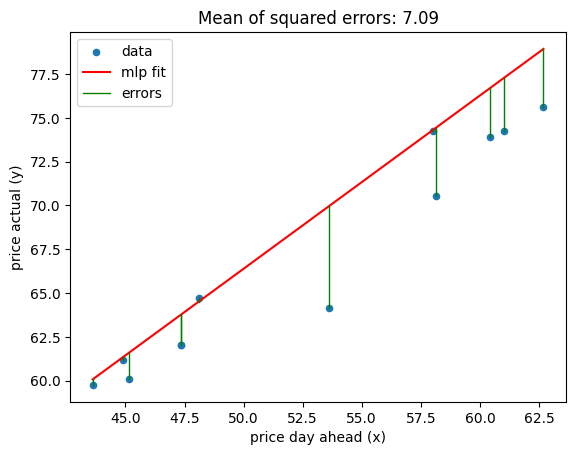

In [50]:
plot_scatter_mlp(test,show_errors=True)

Why? A single neuron basically makes a line, but not a true line because of the activation function. 

We need more neurons.

## Neural Network

The power of a neural network is in the network. This one is:
- Layer 1: 100 neurons
- Layer 2: 10 neurons

Weights: [array([[-5.08041679e-36,  5.68822679e-01,  9.57170035e-02,
         1.27756984e-02,  2.13628823e-02, -1.71044535e-23,
        -5.20097469e-15,  5.05502200e-01, -7.01091311e-36,
        -2.62543007e-32, -1.08250852e-12,  5.73676204e-01,
         5.15141836e-01, -8.49121719e-02, -1.13475307e+00,
        -2.93279004e-01,  2.05802304e-01,  6.52445515e-37,
         2.78536669e-01, -1.12368294e-01,  3.31183374e-01,
         1.50972701e-01,  2.64533926e-32,  8.08039614e-36,
         5.98005438e-37,  4.81717912e-01,  1.68683828e-01,
         3.29484752e-01,  5.07653587e-36, -3.58220762e-14,
         3.71156637e-01,  9.58550483e-25, -1.33356504e-15,
         5.12923808e-01,  5.57528621e-01,  5.04358426e-01,
         6.88679602e-33,  1.45299949e-01,  4.25350606e-01,
         3.01154087e-01, -4.89242733e-01, -2.84508144e-38,
        -1.97628224e-13,  1.43316924e-01, -1.25186712e-30,
        -3.48028484e-34, -1.34381610e-01, -4.43963415e-03,
         2.92688103e-37, -8.47901137e-27,  3.0

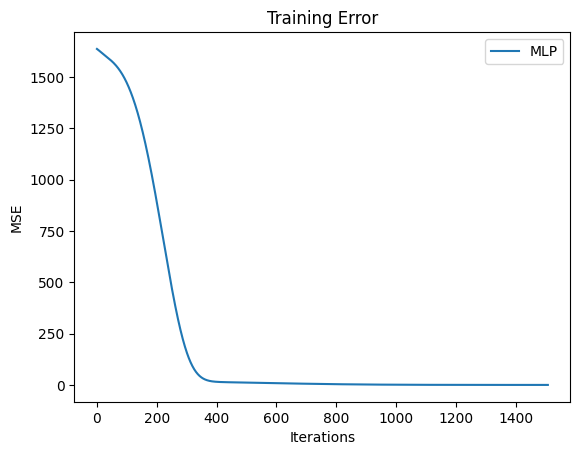

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:24].copy()
y = data['price actual'][:24].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   #early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

Some improvement! But it's not exactly "the promise of AI"

The problem is:
- the model is big (thousands of parameters)
- the data are few (one input value, 12 values total)

### More data: 1000 h

A large part of the "promise of AI" depends on having lots of data

Same model, more data

Weights: [array([[-5.28326450e-07,  7.51179198e-01,  9.95569144e-02,
         1.38733838e-02,  2.39039451e-01, -1.20002925e-02,
        -3.26887672e-02,  6.67199477e-01, -1.30431900e-09,
         4.83618395e-04, -4.28907550e-02,  7.36193995e-01,
         6.91767430e-01,  1.66001538e-01, -1.80971111e-01,
        -2.27189892e-01,  3.71630536e-01,  3.03444657e-14,
         4.54947292e-01, -1.19855595e-01,  5.35454399e-01,
         3.40426135e-01, -4.79224412e-04, -1.85271958e-06,
         1.56124457e-13,  6.60158026e-01,  3.35573151e-01,
         5.01505133e-01, -6.44641242e-11, -2.24363021e-01,
         5.32402886e-01, -9.79076260e-03, -3.09166584e-02,
         6.98950705e-01,  7.27410835e-01,  6.84780042e-01,
        -1.08761035e-01,  3.11103392e-01,  6.26804295e-01,
         4.93954200e-01, -2.85153406e-01, -2.43554098e-15,
        -3.90101216e-02,  1.46422640e-01, -1.55624503e-03,
         3.60006492e-05, -1.20369267e-01, -4.25668011e-03,
         6.08096511e-15, -7.85006392e-03,  5.4

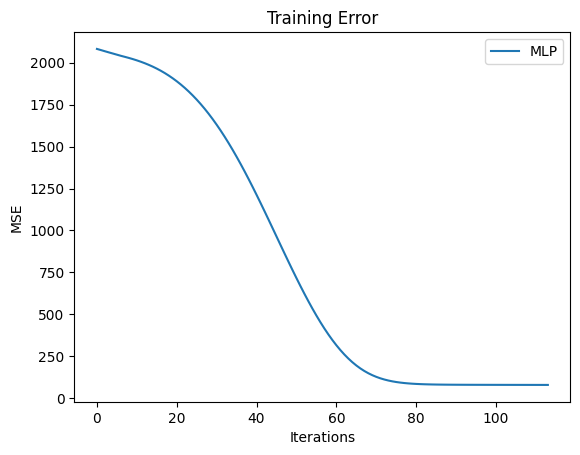

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and targets
data = data.sort_index()
X = data[['price day ahead']][:1000].copy()
y = data['price actual'][:1000].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');

### All Data

The best results will come with all the data and all the features (inputs)

Weights: [array([[ 2.42123790e-002,  1.40553000e-316, -1.05613715e-002, ...,
        -2.90384253e-001, -3.74000035e-001, -3.12014805e-001],
       [-5.29281577e-001,  8.05820574e-318, -1.28919997e-001, ...,
         1.52252378e-001,  7.52172692e-002,  6.01213952e-002],
       [ 4.24347545e-001, -4.42662068e-317,  1.04160888e-001, ...,
         1.10244092e+000,  2.63038187e-001,  4.72221029e-002],
       ...,
       [ 1.21844490e-001,  1.73818144e-316,  1.03757341e-001, ...,
        -1.41987643e-001, -6.42426992e-002, -5.72351535e-002],
       [ 1.13892162e+000, -1.46384675e-316,  3.65280273e-003, ...,
        -1.64351867e-001, -1.39037521e-002,  1.73701198e-001],
       [ 9.59082249e-001,  1.97059649e-316,  1.85975856e-001, ...,
        -1.89725268e-001, -1.47294248e-001, -5.05838484e-002]]), array([[ 8.31018236e-001, -2.35054599e-002,  5.51517295e-001,
        -2.18530546e-316, -1.21854976e-064,  6.26296632e-001,
         8.77232208e-001,  9.60411047e-317,  8.65907273e-214,
         1

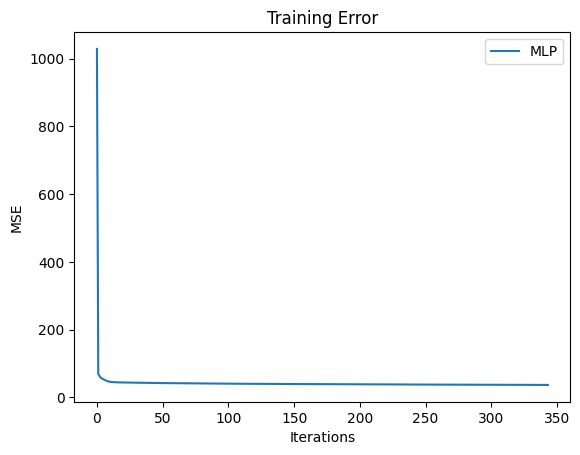

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Extract features and target
data = data.sort_index()
cols = data.columns.to_list()
cols.remove('price actual')
X = data[cols].copy()
y = data['price actual'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a small neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,10),
                   max_iter=100000,
                   random_state=42,
                   early_stopping=True,
                   shuffle=False)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_fit = mlp.predict(X_train_scaled)
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse_train = (y_train-y_fit).__abs__().mean()
mse_test = (y_test-y_pred).__abs__().mean()

# Prepare data for plotting
train = pd.DataFrame(X_train)
train['price actual'] = y_train
train['price mlp fit'] = y_fit

test = pd.DataFrame(X_test)
test['price actual'] = y_test
test['price mlp fit'] = y_pred

# Print model
print("Weights:", mlp.coefs_)
print("Biases:", mlp.intercepts_)
print("Number of iterations:", mlp.n_iter_)
print("Loss:", mlp.loss_)
print("Best loss:", mlp.best_loss_)
print("Number of layers:", mlp.n_layers_)
print("Number of outputs:", mlp.n_outputs_)

# Print results
print("\nMean Squared Error (train):", mse_train)
print("Mean Squared Error: (test)", mse_test)

pd.DataFrame({'MLP':mlp.loss_curve_}).plot(title='Training Error',ylabel='MSE',xlabel='Iterations');